## Purpose:
This notebook identifies global neural activation states shared across all trials, using modern nonlinear clustering (UMAP + HDBSCAN).

## What is being done:
- For every trial, the neural spectrogram is converted into chunked windows (e.g., 10 time bins averaged).
- Each chunk represents a short neural activation pattern.
- All chunks from all trials are concatenated into a single dataset.
UMAP is applied:
10D UMAP for clustering
2D UMAP for visualization
HDBSCAN is run on the 10D embedding:
Automatically finds the number of clusters
Labels stable cluster cores
Marks ambiguous chunks as noise
- Store mapping from cluster → list of chunk descriptors, e.g.:
{
    0: ["train/t15.2023.09.01/trial_0142_chunk3_bins30-40", ...],
    1: [...],
    ...
}
Visualize clusters in UMAP 2D space to show cluster structures and noise points.
## Why:
Within-trial clustering finds structure inside each trial, but across-trial clustering reveals neural states that repeat across different sentences, times, and sessions.
UMAP+HDBSCAN is used because:
Neural data forms nonlinear manifolds
KMeans/CURE cannot find natural density-separated structures
HDBSCAN automatically detects the number of clusters
UMAP makes manifold structure visible and clusterable


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import pickle
import json, pickle

import clustering_util_full as cu

csv_path = Path("trial_index.csv")
df_trials = pd.read_csv(csv_path)
len(df_trials), df_trials.head()


(10948,
           session  split       trial  \
 0  t15.2023.08.11  train  trial_0000   
 1  t15.2023.08.11  train  trial_0001   
 2  t15.2023.08.11  train  trial_0002   
 3  t15.2023.08.11  train  trial_0003   
 4  t15.2023.08.11  train  trial_0004   
 
                                                 path  
 0  /Users/erika/Desktop/Computational Tools for D...  
 1  /Users/erika/Desktop/Computational Tools for D...  
 2  /Users/erika/Desktop/Computational Tools for D...  
 3  /Users/erika/Desktop/Computational Tools for D...  
 4  /Users/erika/Desktop/Computational Tools for D...  )

In [19]:
# sample unique trials (one row per trial) to avoid duplicate-trial merges
train_trials = df_trials[df_trials["split"]=="train"].drop_duplicates(subset="trial")
desired_n = 500
n_available = len(train_trials)
n_samples = min(desired_n, n_available)
if n_samples < desired_n:
    print(f"Requested {desired_n} samples but only {n_available} unique trials available. Sampling {n_samples} instead.")
df_sample_global = train_trials.sample(n=n_samples, random_state=0)  # sample up to available unique trials
print("Sampled subset (unique trials):")
print(df_sample_global.head())
print("Total sampled trials:", len(df_sample_global))


Requested 500 samples but only 364 unique trials available. Sampling 364 instead.
Sampled subset (unique trials):
            session  split       trial  \
596  t15.2023.08.13  train  trial_0308   
258  t15.2023.08.11  train  trial_0258   
45   t15.2023.08.11  train  trial_0045   
26   t15.2023.08.11  train  trial_0026   
219  t15.2023.08.11  train  trial_0219   

                                                  path  
596  /Users/erika/Desktop/Computational Tools for D...  
258  /Users/erika/Desktop/Computational Tools for D...  
45   /Users/erika/Desktop/Computational Tools for D...  
26   /Users/erika/Desktop/Computational Tools for D...  
219  /Users/erika/Desktop/Computational Tools for D...  
Total sampled trials: 364


In [20]:
WINDOW_SIZE = 10
OVERLAP = 0
PCA_DIM_FOR_UMAP = None  

labels_global, X_umap_cluster, X_umap_plot, meta = cu.evaluate_umap_hdbscan(
    df_sample_global,
    window_size=WINDOW_SIZE,
    overlap=OVERLAP,
    pca_dim=PCA_DIM_FOR_UMAP,
    max_trials=None,          
    umap_cluster_dim=10,
    umap_plot_dim=2,
    min_cluster_size=40,      
    min_samples=10            
)

# assign label column to meta (must be same length)
assert len(labels_global) == len(meta), "labels and meta length mismatch"
meta["cluster"] = labels_global

# THEN merge (use the sampled trials dataframe and ensure one row per trial)
df_trials_small = df_sample_global[["trial", "session", "split", "path"]].drop_duplicates(subset="trial")
print("len(df_sample_global):", len(df_sample_global))
print("len(df_trials_small):", len(df_trials_small))
print("unique trials in df_trials_small:", df_trials_small['trial'].nunique())
meta_full = meta.merge(df_trials_small, on="trial", how="left")

meta.head(), np.unique(labels_global, return_counts=True)

print("meta (first 5 rows) BEFORE merge:")
print(meta.head())


/Users/erika/Desktop/Computational Tools for Data Science /.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/erika/Desktop/Computational Tools for Data Science /.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/erika/Desktop/Computational Tools for Data Science /.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/erika/Desktop/Computational Tools for Data Science /.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/erika/Desktop/Computationa

len(df_sample_global): 364
len(df_trials_small): 364
unique trials in df_trials_small: 364
meta (first 5 rows) BEFORE merge:
        trial  chunk_idx  start_bin  end_bin  cluster
0  trial_0308          0          0       10        0
1  trial_0308          1         10       20        0
2  trial_0308          2         20       30        0
3  trial_0308          3         30       40        0
4  trial_0308          4         40       50        0


In [21]:
# print("len(meta):", len(meta))
# print("len(labels_global):", len(labels_global))

# df_trials_small = df_trials[["trial", "session", "split", "path"]].drop_duplicates()
# print("len(df_trials_small):", len(df_trials_small))

# meta_full = meta.merge(df_trials_small, on="trial", how="left")
# print("len(meta_full):", len(meta_full))

# print("len(labels_global):", len(labels_global))
print("len(meta):", len(meta))
print("len(meta_full):", len(meta_full))
# print("meta.index.is_unique:", meta.index.is_unique)
# print("meta_full.index.is_unique:", meta_full.index.is_unique)
# # Sanity: compare to embedding shapes
# print("X_umap_cluster.shape:", getattr(X_umap_cluster, "shape", None))
# print("X_umap_plot.shape:", getattr(X_umap_plot, "shape", None))


len(meta): 18564
len(meta_full): 18564


In [22]:
# merge meta with df_sample_global to get session, split, path (ensure one row per trial)
df_trials_small = df_sample_global[["trial", "session", "split", "path"]].drop_duplicates(subset="trial")
print("After dedup: len(df_trials_small):", len(df_trials_small))
meta_full = meta.merge(df_trials_small, on="trial", how="left")

meta_full["cluster"] = labels_global

print("\nmeta_full (first 5 rows) AFTER merge & cluster assignment:")
print(meta_full.head())


After dedup: len(df_trials_small): 364

meta_full (first 5 rows) AFTER merge & cluster assignment:
        trial  chunk_idx  start_bin  end_bin  cluster         session  split  \
0  trial_0308          0          0       10        0  t15.2023.08.13  train   
1  trial_0308          1         10       20        0  t15.2023.08.13  train   
2  trial_0308          2         20       30        0  t15.2023.08.13  train   
3  trial_0308          3         30       40        0  t15.2023.08.13  train   
4  trial_0308          4         40       50        0  t15.2023.08.13  train   

                                                path  
0  /Users/erika/Desktop/Computational Tools for D...  
1  /Users/erika/Desktop/Computational Tools for D...  
2  /Users/erika/Desktop/Computational Tools for D...  
3  /Users/erika/Desktop/Computational Tools for D...  
4  /Users/erika/Desktop/Computational Tools for D...  


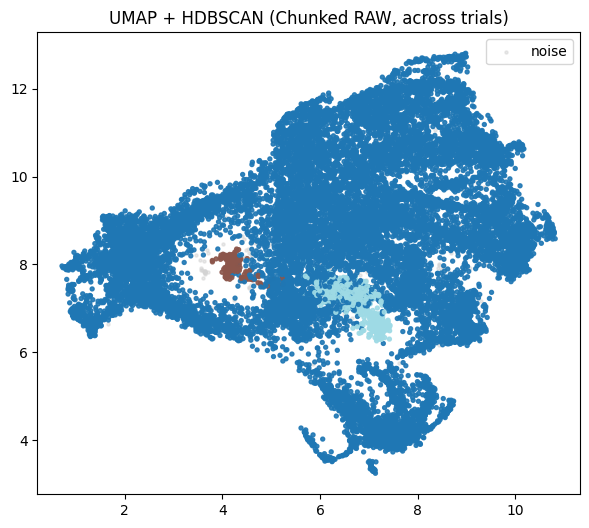

In [23]:
plt.figure(figsize=(7,6))
mask_noise = (labels_global == -1)

plt.scatter(X_umap_plot[mask_noise,0], X_umap_plot[mask_noise,1],
            c="lightgray", s=5, alpha=0.5, label="noise")

non_noise = ~mask_noise
plt.scatter(X_umap_plot[non_noise,0], X_umap_plot[non_noise,1],
            c=labels_global[non_noise], cmap="tab20", s=8, alpha=0.9)

plt.title("UMAP + HDBSCAN (Chunked RAW, across trials)")
plt.legend()
plt.show()


In [24]:
# exclude noise cluster (-1)
valid_clusters = sorted(c for c in np.unique(labels_global) if c != -1)

cluster_to_chunks = {}

for c in valid_clusters:
    df_c = meta_full[meta_full["cluster"] == c].copy()
    # create a human-readable identifier per chunk
    df_c["descriptor"] = df_c.apply(
        lambda r: f"{r['split']}/{r['session']}/{r['trial']}_chunk{r['chunk_idx']}_bins{r['start_bin']}-{r['end_bin']}",
        axis=1
    )
    cluster_to_chunks[int(c)] = df_c["descriptor"].tolist()

print("\nExample: first few entries of cluster_to_chunks:")
# show a sample
for cid, items in cluster_to_chunks.items():
    print(f"Cluster {cid}, {len(items)} chunks")
    print("  ", items[:5], "...")
    print()



Example: first few entries of cluster_to_chunks:
Cluster 0, 17626 chunks
   ['train/t15.2023.08.13/trial_0308_chunk0_bins0-10', 'train/t15.2023.08.13/trial_0308_chunk1_bins10-20', 'train/t15.2023.08.13/trial_0308_chunk2_bins20-30', 'train/t15.2023.08.13/trial_0308_chunk3_bins30-40', 'train/t15.2023.08.13/trial_0308_chunk4_bins40-50'] ...

Cluster 1, 185 chunks
   ['train/t15.2024.04.25/trial_0363_chunk0_bins0-10', 'train/t15.2024.04.25/trial_0363_chunk1_bins10-20', 'train/t15.2024.04.25/trial_0363_chunk2_bins20-30', 'train/t15.2024.04.25/trial_0363_chunk3_bins30-40', 'train/t15.2024.04.25/trial_0363_chunk4_bins40-50'] ...

Cluster 2, 524 chunks
   ['train/t15.2024.04.25/trial_0363_chunk6_bins60-70', 'train/t15.2024.04.25/trial_0363_chunk7_bins70-80', 'train/t15.2024.04.25/trial_0363_chunk9_bins90-100', 'train/t15.2024.04.25/trial_0363_chunk10_bins100-110', 'train/t15.2024.04.25/trial_0363_chunk11_bins110-120'] ...



In [25]:


with open("global_umap_hdbscan_clusters.pkl", "wb") as f:
    pickle.dump(cluster_to_chunks, f)

with open("global_umap_hdbscan_clusters.json", "w") as f:
    json.dump(cluster_to_chunks, f, indent=2)

meta_full.to_csv("global_umap_hdbscan_meta.csv", index=False)

print("\nSaved:")
print("  global_umap_hdbscan_clusters.pkl / .json")
print("  global_umap_hdbscan_meta.csv")




Saved:
  global_umap_hdbscan_clusters.pkl / .json
  global_umap_hdbscan_meta.csv
